In [1]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/jorge/thesis")

In [5]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = 'mv_lion:latest'
anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
seq = anim.read_anim_seq()

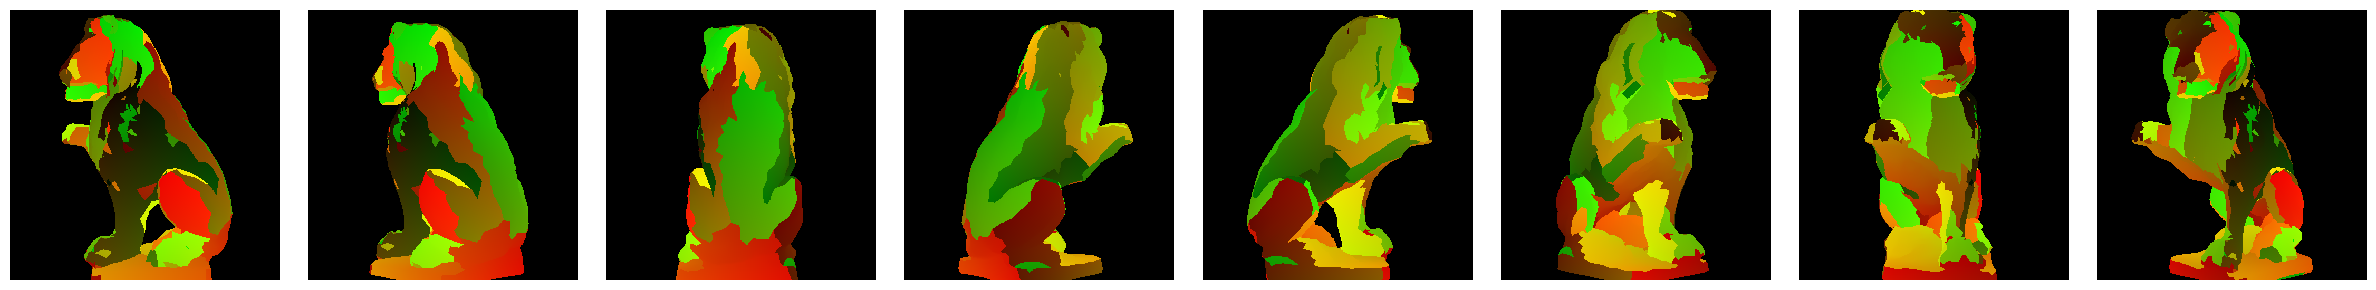

In [6]:
from text3d2video.utilities.ipython_utils import display_ims

display_ims(seq.render_rgb_uv_maps())

In [17]:
frame_i = 0
cam = seq.cams[frame_i]
mesh = seq.meshes[frame_i]
verts_uvs = seq.verts_uvs
faces_uvs = seq.faces_uvs

# Verify Computing UV res for a view

To compute the uv resolution for a view, we find one that leads to minimal warping. Assigned resolution is correct if squares look like the same size in both images

127


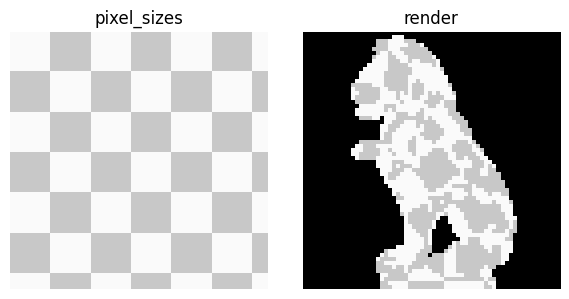

In [19]:
import torchvision.transforms.functional as TF

from text3d2video.mip import view_uv_res
from text3d2video.rendering import render_texture
from text3d2video.util import chw_to_hwc, hwc_to_chw
from text3d2video.utilities.testing_utils import checkerboard_img

resolution = 64
uv_res = view_uv_res(
    cam, mesh, verts_uvs, faces_uvs, resolution=resolution, quantile=0.90
)

print(uv_res)

n_squares = 6
square_size = int(resolution / n_squares)

tex = TF.to_tensor(checkerboard_img(res=uv_res, square_size=square_size)).cuda()
tex = chw_to_hwc(tex).cuda()
tex_im = TF.to_pil_image(hwc_to_chw(tex.cpu()))

pixel_sizes = checkerboard_img(res=resolution, square_size=square_size)

render = render_texture(
    mesh,
    cam,
    tex,
    verts_uvs,
    faces_uvs,
    return_pil=True,
    resolution=resolution,
    sampling_mode="nearest",
)[0]

ims = {}
# ims["tex"] = tex_im
ims["pixel_sizes"] = pixel_sizes
ims["render"] = render

display_ims(list(ims.values()), titles=list(ims.keys()))